# Milestone 2

Import all needed libraries and read the data set that has been cleaned as a result of milestone 1. 

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
df_bike_clean = pd.read_csv("bike_data_clean.csv")
df_bike_clean.head()

,START TIME,BIKE ID,TRIP DURATION,FROM STATION ID,USER TYPE,GENDER,FROM LATITUDE,FROM LONGITUDE,AGE
0,04/03/2019 08:29:54 AM,5313,537,18,Subscriber,Male,41.883132,-87.637321,37
1,04/03/2019 08:29:52 AM,5884,224,137,Subscriber,Male,41.862378,-87.651062,54
2,04/03/2019 08:29:52 AM,4048,1085,210,Subscriber,Male,41.903450,-87.667747,32
3,04/03/2019 08:29:50 AM,2638,309,96,Subscriber,Male,41.884616,-87.644571,31
4,04/03/2019 08:29:45 AM,3179,501,77,Subscriber,Male,41.882242,-87.641066,41


# Add new feature: `weekdays`

Sort the starting time by weekdays. In one hot encoding, one category is left out in order to avoid  multicollinearity. (in this case: `Sunday`)


First, the `START TIME` needs to be converted to datetime value in order to be usable for the following task. We keep the original cleaned data set by making a copy of it to continue with the steps.

In [3]:
# sort into weekdays
# one hot coded columns method

# first convert START TIME to datetime value
df_bike_clean['START TIME'] = pd.to_datetime(df_bike_clean['START TIME'])
df_bike_cleaned = df_bike_clean.copy()

# extract day the of the week
df_bike_cleaned['DAY OF WEEK'] = df_bike_cleaned["START TIME"].dt.day_name()

#ChatGPT: i want to improve the hot one coding because it does not start with monday, the column starts with wednesday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_bike_cleaned['DAY OF WEEK'] = pd.Categorical(df_bike_cleaned['DAY OF WEEK'], categories=day_order, ordered=True)
# until here ------------------

days_of_week = pd.get_dummies(df_bike_cleaned['DAY OF WEEK'])
days_of_week.drop(columns=["Sunday"], inplace=True)

# add column to database
df_bike_cleaned = pd.concat([df_bike_cleaned, days_of_week], axis=1)

# we do not need the column anymore
df_bike_cleaned.drop(columns=['DAY OF WEEK'], inplace=True)

df_bike_cleaned.head()

,START TIME,BIKE ID,TRIP DURATION,FROM STATION ID,USER TYPE,GENDER,FROM LATITUDE,FROM LONGITUDE,AGE,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,2019-04-03 08:29:54,5313,537,18,Subscriber,Male,41.883132,-87.637321,37,False,False,True,False,False,False
1,2019-04-03 08:29:52,5884,224,137,Subscriber,Male,41.862378,-87.651062,54,False,False,True,False,False,False
2,2019-04-03 08:29:52,4048,1085,210,Subscriber,Male,41.903450,-87.667747,32,False,False,True,False,False,False
3,2019-04-03 08:29:50,2638,309,96,Subscriber,Male,41.884616,-87.644571,31,False,False,True,False,False,False
4,2019-04-03 08:29:45,3179,501,77,Subscriber,Male,41.882242,-87.641066,41,False,False,True,False,False,False


# Add new feature: `hour`

In [4]:
#hour of day 
df_bike_cleaned['START TIME'] = pd.to_datetime(df_bike_cleaned['START TIME'])
df_bike_cleaned['HOUR OF DAY'] = df_bike_cleaned['START TIME'].dt.hour
df_bike_cleaned.tail()

,START TIME,BIKE ID,TRIP DURATION,FROM STATION ID,USER TYPE,GENDER,FROM LATITUDE,FROM LONGITUDE,AGE,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,HOUR OF DAY
156218,2019-03-05 17:18:57,4667,234,145,Subscriber,Male,41.898587,-87.621915,68,False,True,False,False,False,False,17
156219,2019-03-05 17:18:52,1667,387,638,Subscriber,Male,41.878419,-87.640977,36,False,True,False,False,False,False,17
156220,2019-03-05 17:18:51,1694,591,110,Subscriber,Male,41.893992,-87.629318,48,False,True,False,False,False,False,17
156221,2019-03-05 17:18:42,1464,335,44,Subscriber,Male,41.884730,-87.627734,40,False,True,False,False,False,False,17
156222,2019-03-05 17:18:39,2699,492,44,Subscriber,Male,41.884730,-87.627734,60,False,True,False,False,False,False,17


# Visualization:
Number of bike trips starting and concurrent bike usage for every `hour` of day

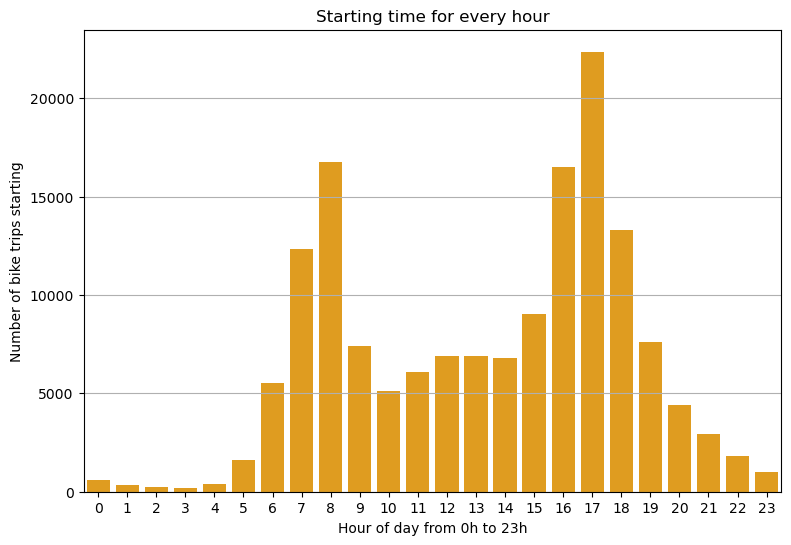

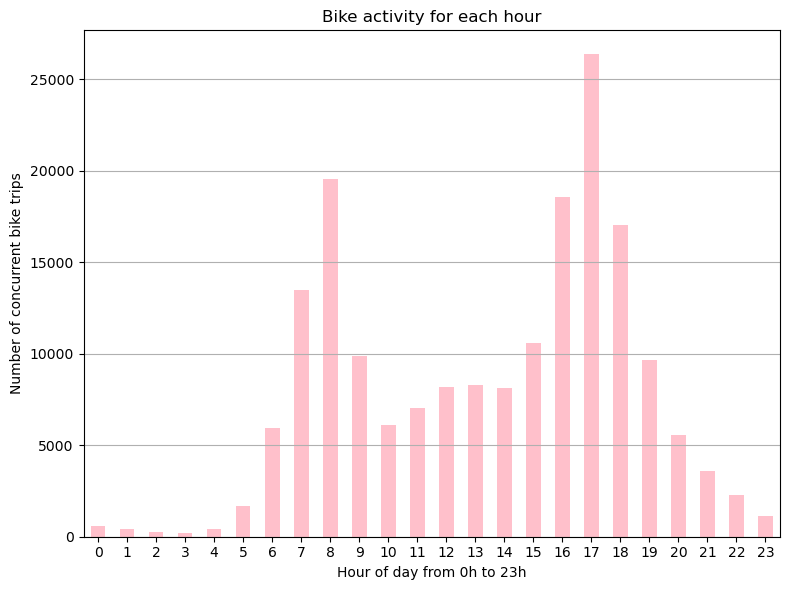

In [5]:
# Visualization 1
# bar chart how many trips startet in each hour
plt.figure(figsize=(9,6))
sns.countplot(x='HOUR OF DAY', data=df_bike_cleaned, color= "orange")

plt.title("Starting time for every hour")
plt.xlabel("Hour of day from 0h to 23h")
plt.ylabel("Number of bike trips starting")
plt.grid(axis= 'y')
plt.show()

# Visualization 2
# determine end time: end time = start time plus the trip duration
df_bike_cleaned['END TIME'] = df_bike_cleaned['START TIME'] + pd.to_timedelta(df_bike_cleaned['TRIP DURATION'], unit='s')

# we need an array or series to count bike trips each hour
count_hours = pd.Series(0, index=range(24))
# count how many bike trips started in each hour
for _, row in df_bike_cleaned.iterrows(): 

    start_hour = row['HOUR OF DAY']
    end_time = row['END TIME']

    end_hour = end_time.hour

    for hour in range(start_hour, end_hour + 1):
        # for every hour from start to end: add one count 
        count_hours[hour % 24] += 1  

plt.figure(figsize=(8, 6))
count_hours.sort_index().plot(kind='bar', color='pink')

plt.title('Bike activity for each hour')
plt.xlabel('Hour of day from 0h to 23h')
plt.ylabel('Number of concurrent bike trips')
plt.xticks(rotation=0) 
plt.grid(axis='y')
plt.tight_layout()
plt.show()


The overall graphs are very similar with the only difference in the numbers on the y axis. This is to be expected since some bike trips are counted multiple times since it is one count for every hour it reaches. 
Another conclusion that can be drawn from the comparison of these two graphs is that many trips do not exceed one hour durations since the structure would not be similar in that case. 

In [6]:
bike_trip_mean = df_bike_cleaned['TRIP DURATION'].aggregate('mean')
print("AVG trip duration: ", bike_trip_mean)

bike_trip_median = df_bike_cleaned['TRIP DURATION'].aggregate('median')
print("Median trip duration: ", bike_trip_median)

print("Max trip duration: ", df_bike_cleaned['TRIP DURATION'].max())

AVG trip duration:  824.4359089250622
Median trip duration:  524.0
Max trip duration:  6096430


Since there are very few bike trips that exceed an duration of two hours in comparison to the amount under two hours,
we will exclude any entry over 2 hours.
Outliers like a max trip duration of 6,096,430 seconds (about 1693hours) seem unrealistic and will distort the graphs.


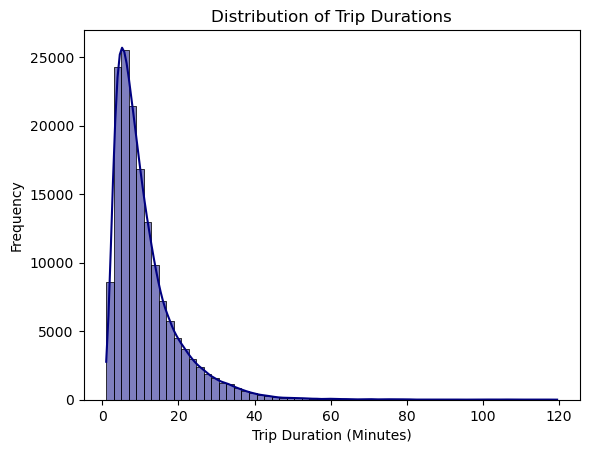

In [7]:
df_bike_cleaned = df_bike_cleaned[df_bike_cleaned["TRIP DURATION"] <= 7200]
df_bike_cleaned["TRIP DURATION"] = df_bike_cleaned["TRIP DURATION"] / 60
sns.histplot(
    df_bike_cleaned["TRIP DURATION"],
    bins=60,
    kde=True,
    color='navy'
)
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Frequency')
plt.show()


# Age distribution


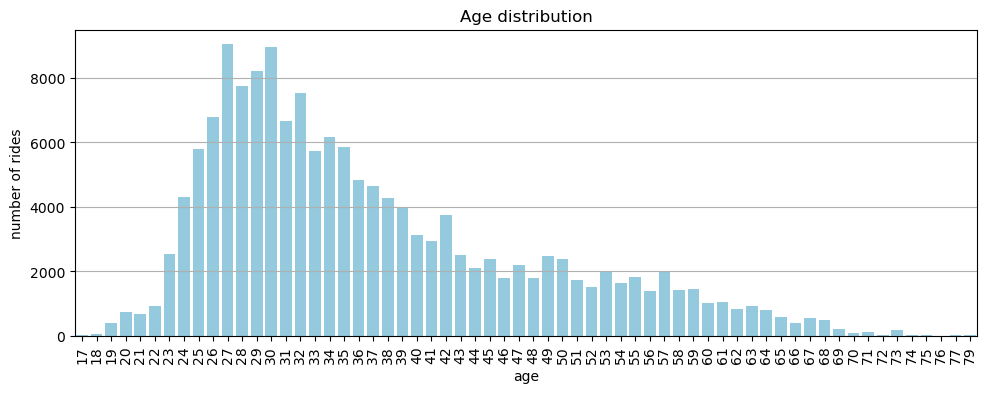

In [8]:
plt.figure(figsize=(10,4))
sns.countplot(x='AGE', data=df_bike_cleaned, color= "skyblue")

plt.title("Age distribution")
plt.xlabel("age")
plt.ylabel("number of rides")
plt.grid(axis= 'y')
plt.tight_layout()
plt.xticks(rotation = 90)
plt.show()

# Introduction to geographical data engineering 

Since Chicago is divided into **77 different community areas**, this could be an useful way to subdivide our data into different regions, each with different characteristics that might prove interesting for our `Trip duration`. 

In [9]:
community_data = pd.read_csv("CommunityDataClean_2019.csv", sep=";")
community_data_clean = community_data.filter(['OBJECTID','GEOG', 'TOT_POP','TOT_ACRES', 'DROVE_AL', 'TRANSIT', 'WALK_BIKE',
                                                'MEDINC', 'OWN_OCC_HU', 'RENT_OCC_HU', 'UNEMP', 'IN_LBFRC'], axis=1)
community_data_clean.head()

,OBJECTID,GEOG,TOT_POP,TOT_ACRES,DROVE_AL,TRANSIT,WALK_BIKE,MEDINC,OWN_OCC_HU,RENT_OCC_HU,UNEMP,IN_LBFRC
0,14,Albany Park,51992,1229.160488,13090,8606,1548,58128.20513,6738,9825,2060,29224
1,57,Archer Heights,13142,1283.804076,3638,988,262,46632.12435,2110,1784,605,6561
2,34,Armour Square,13455,637.424147,1984,1138,1265,26466.21622,1927,3280,772,6620
3,70,Ashburn,43792,3109.741438,13110,2777,44,66560.12658,10946,2036,2904,22287
4,71,Auburn Gresham,46278,2411.968642,9475,4388,200,31694.19134,7389,9722,4376,20714


**Source**: https://datahub.cmap.illinois.gov/maps/e22e50bf9e7547d3aa257edc4c466330/about 

The data above is provided by the Chicago Metropolitan Agency for Planning and can be found under CCA_2019
Based on the dataset, which provided detailed information on 231 different charateristics, the following charateristics has been chosen:

+ `GEOG`, `OBJECTID` : Name and ID of the community area, this is included in order to merge the dataset together and will be removed afterwards
+ `TOT_POP`, `TOT_ACRES`, : Total population will be divided by total area in order to find out the population density of a region, which could be a good indicator for increased bike usage.
+ `MEDINC`: Median income generally is an indicator for how wealthy and well established an area is, therefore this might point to an increase in alternative transportation availability, or it could lower the bike usage, since wealthier households will probably have multiple cars. Either way it will be useful for the analysis
+ `DROVE_AL`, `TRANSIT`, `WALK_BIKE`: All important indicators of the public transportation availability of an area, will be combined together to create a ratio of vehicles to total transportation usage 
+ `OWN_OCC_HU`, `RENT_OCC_HU`: Areas with more renters often have younger, more mobile populations who are more likely to use bike-sharing, while low-density, owner-heavy neighborhoods may result in fewer, longer rides. These two metrics will be combined together to create a ratio of Owner/Renter in an area 
+ `UNEMP`, `IN_LBFRC`: The ratio of unemployment can be deduced through dividing the amount of unemployed people through the total amount of the labor force. This could be a good indicator since an commuter-heavy areas might generate short, high-volume trips during rush hours

In [10]:
community_data_clean['POP_DENSITY'] = (community_data_clean['TOT_POP'] / community_data_clean['TOT_ACRES']).round(2) # people per acre
community_data_clean['VEH_RATIO'] = (community_data_clean['DROVE_AL'] / (community_data_clean['DROVE_AL'] + community_data_clean['TRANSIT'] + community_data_clean['WALK_BIKE'])).round(2)
community_data_clean['RENT_RATIO'] = (community_data_clean['RENT_OCC_HU'] / (community_data_clean['OWN_OCC_HU'] + community_data_clean['RENT_OCC_HU'])).round(2)
community_data_clean['UNEMP_RATIO'] = (community_data_clean['UNEMP'] / community_data_clean['IN_LBFRC']).round(2)


community_data_enhanced = community_data_clean.drop([
    'TOT_POP', 'TOT_ACRES', 'DROVE_AL', 'TRANSIT', 'WALK_BIKE',
    'OWN_OCC_HU', 'RENT_OCC_HU', 'UNEMP', 'IN_LBFRC'], axis=1)
community_data_enhanced['MEDINC'] = community_data_enhanced['MEDINC'].round(2) 
community_data_enhanced = community_data_enhanced.rename(columns={
    'GEOG': 'COMMUNITY',
    'MED_AGE': 'MEDIAN_AGE',
    'NO_VEH': 'NO_VEHICLES',
    'MEDINC': 'MEDIAN_INCOME',
    'POP_DENSITY': 'POPULATION_DENSITY',
    'VEH_RATIO': 'VEHICLE_RATIO',
    'RENT_RATIO': 'RENTAL_RATIO',
    'UNEMP_RATIO': 'UNEMPLOYMENT_RATIO'
})
community_data_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OBJECTID            77 non-null     int64  
 1   COMMUNITY           77 non-null     object 
 2   MEDIAN_INCOME       77 non-null     float64
 3   POPULATION_DENSITY  77 non-null     float64
 4   VEHICLE_RATIO       77 non-null     float64
 5   RENTAL_RATIO        77 non-null     float64
 6   UNEMPLOYMENT_RATIO  77 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 4.3+ KB


In [11]:
boundaries = pd.read_csv("Boundaries_Community.csv", sep=",")
boundaries.drop(['AREA_NUM_1', 'SHAPE_AREA', 'SHAPE_LEN'], axis=1, inplace=True)
boundaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   the_geom    77 non-null     object
 1   AREA_NUMBE  77 non-null     int64 
 2   COMMUNITY   77 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.9+ KB


Source: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-Map/cauq-8yn6

The data is provided by the City of Chicago and denotes the area boundaries of 77 different community areas as above, since the `AREA_NUMBE`from this dataset and `OBJECTID` from the previous dataset did not match up, some manual work had to be done in order to match up both. 

Since we are only interested in the boundaries of these areas, most of the other attributes were dropped, since they are not of relevancy to us. Afterwards, the 2 dataset will be combined.

In [12]:
boundaries_community = boundaries.merge(
    community_data_enhanced, 
    left_on='AREA_NUMBE', 
    right_on='OBJECTID', 
    how='inner')
boundaries_community.drop(['OBJECTID', 'AREA_NUMBE', 'COMMUNITY_x'], axis=1, inplace=True) # drop redundant columns
boundaries_community.rename(columns={'COMMUNITY_y': 'COMMUNITY'}, inplace=True)
boundaries_community.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   the_geom            77 non-null     object 
 1   COMMUNITY           77 non-null     object 
 2   MEDIAN_INCOME       77 non-null     float64
 3   POPULATION_DENSITY  77 non-null     float64
 4   VEHICLE_RATIO       77 non-null     float64
 5   RENTAL_RATIO        77 non-null     float64
 6   UNEMPLOYMENT_RATIO  77 non-null     float64
dtypes: float64(5), object(2)
memory usage: 4.3+ KB


Since we also want to match up each station with its corresponding area, we have to:

+ **Parse** each boundary’s polygon geometry from `the_geom` as well as the longitude and lattitude from each stations into proper GeoDataFrames with CRS ESRI:103270 (Code for Chicago)
+ **Spatially join** each point that lays within an area's polygon, so that it inherits the name of the `COMMUNITY`. We use an inner join in order to make sure that no information will be lost, even at the expense of missing some rows, since some stations' location might have lay outside our community boundaries 
+ **Merge** all per community metrics which we have defined before 
+ **Drop** redundant information

In [13]:
# Merge bike data with boundaries data
# 1) Parse the WKT polygons and set a GeoDataFrame
boundaries_community['geometry'] = boundaries_community['the_geom'].apply(wkt.loads)
boundaries_gdf = gpd.GeoDataFrame(boundaries_community,
                                  geometry='geometry',
                                  crs='ESRI:103270') # Chicago CRS

# 2) Turn bike_clean points into a GeoDataFrame
df_bike_cleaned['geometry'] = gpd.points_from_xy(
    df_bike_cleaned['FROM LONGITUDE'],
    df_bike_cleaned['FROM LATITUDE']
)
bike_gdf = gpd.GeoDataFrame(df_bike_cleaned,
                            geometry='geometry',
                            crs='ESRI:103270')

# 3) Spatial join: each point gets the COMMUNITY it falls within
bike_community = gpd.sjoin(
    bike_gdf,
    boundaries_gdf[['COMMUNITY','geometry']],
    how='inner'
)

bike_community = bike_community.merge(
    community_data_enhanced,
    on='COMMUNITY',
    how='inner'
)

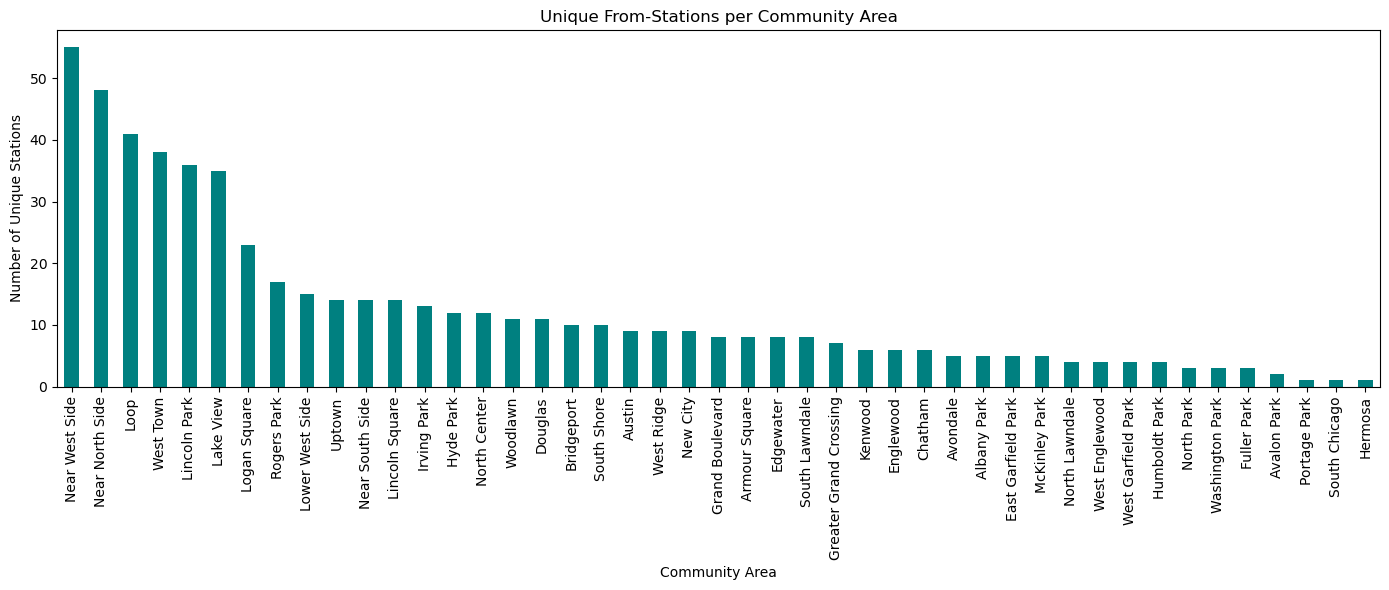

In [14]:
# 1) count unique 'FROM STATION ID' per COMMUNITY
station_counts = (
    bike_community
      .groupby('COMMUNITY')['FROM STATION ID']
      .nunique()
      .sort_values(ascending=False)
)

# 2) plot as bar chart
plt.figure(figsize=(14, 6))
station_counts.plot(
    kind='bar',
    color='teal'
)
plt.title('Unique From-Stations per Community Area')
plt.xlabel('Community Area')
plt.ylabel('Number of Unique Stations')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

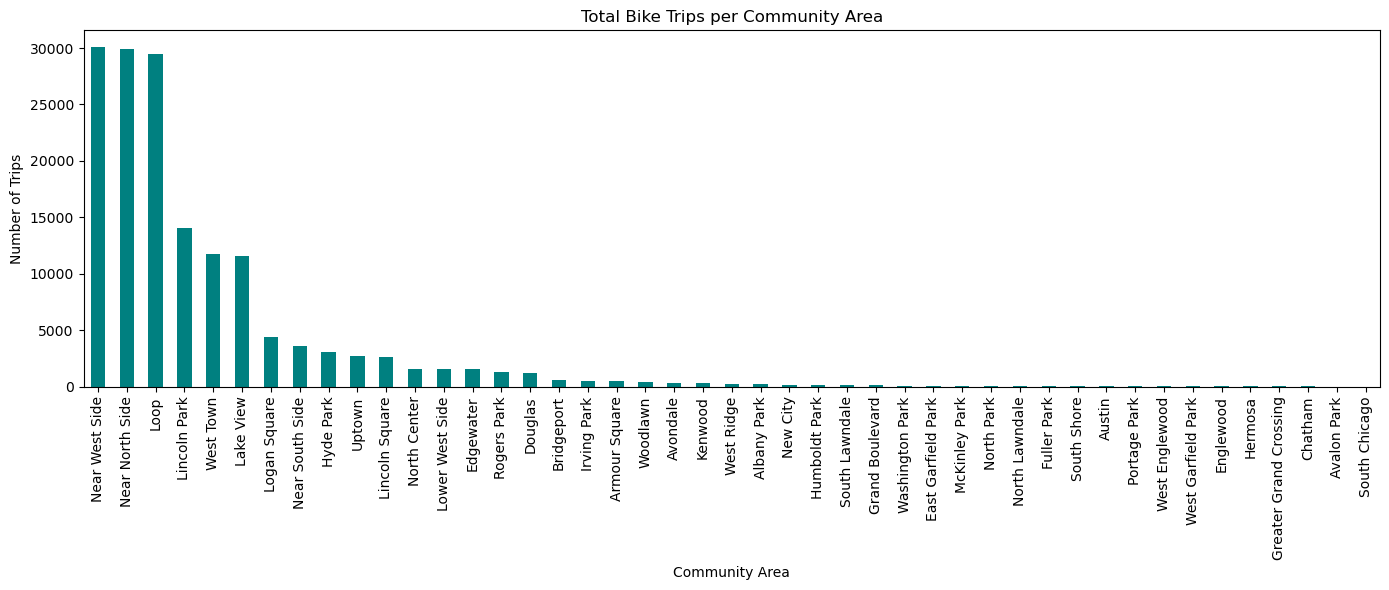

In [15]:
# 1) count all trips per COMMUNITY
trip_counts = bike_community.groupby('COMMUNITY').size().sort_values(ascending=False)

# 2) bar chart
plt.figure(figsize=(14, 6))
trip_counts.plot(kind='bar', color='teal')
plt.title('Total Bike Trips per Community Area')
plt.xlabel('Community Area')
plt.ylabel('Number of Trips')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


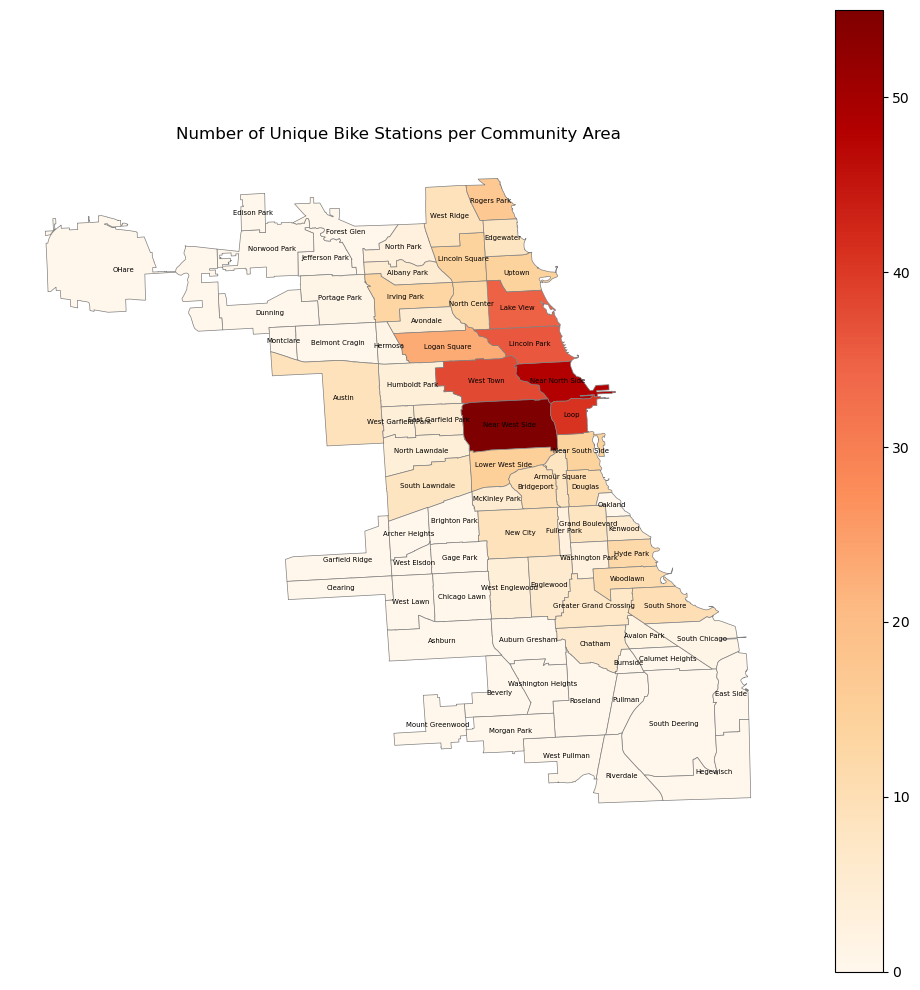

In [16]:
# project boundaries to Web-Mercator
boundaries_plot = boundaries_gdf.to_crs(epsg=3857)

# add station counts
boundaries_plot['station_counts'] = (
    boundaries_plot['COMMUNITY']
      .map(station_counts)
      .fillna(0)
      .astype(int)
)

# compute centroids for labeling
centroids = boundaries_plot.geometry.centroid
boundaries_plot['centroid_x'] = centroids.x
boundaries_plot['centroid_y'] = centroids.y

# plot choropleth
fig, ax = plt.subplots(figsize=(10, 10))
boundaries_plot.plot(
    column='station_counts',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax
)

# add community labels
for _, row in boundaries_plot.iterrows():
    ax.text(
        row.centroid_x, 
        row.centroid_y, 
        row.COMMUNITY, 
        fontsize=5, 
        ha='center',
        va='center'
    )

ax.set_axis_off()
plt.title('Number of Unique Bike Stations per Community Area')
plt.tight_layout()
plt.show()

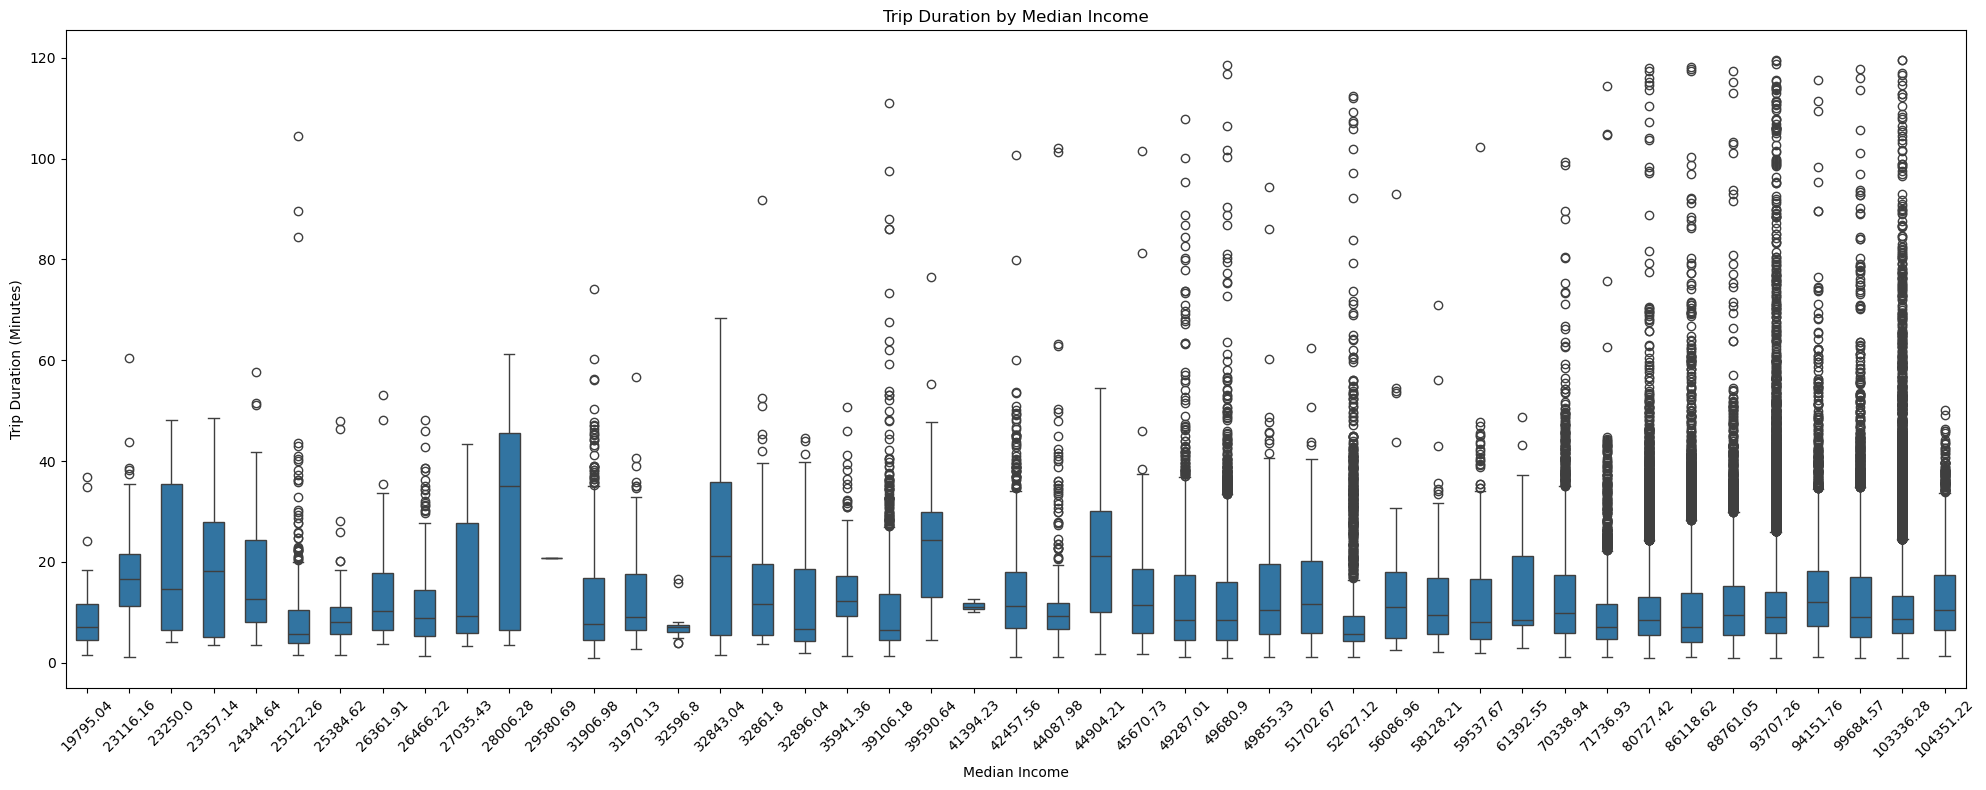

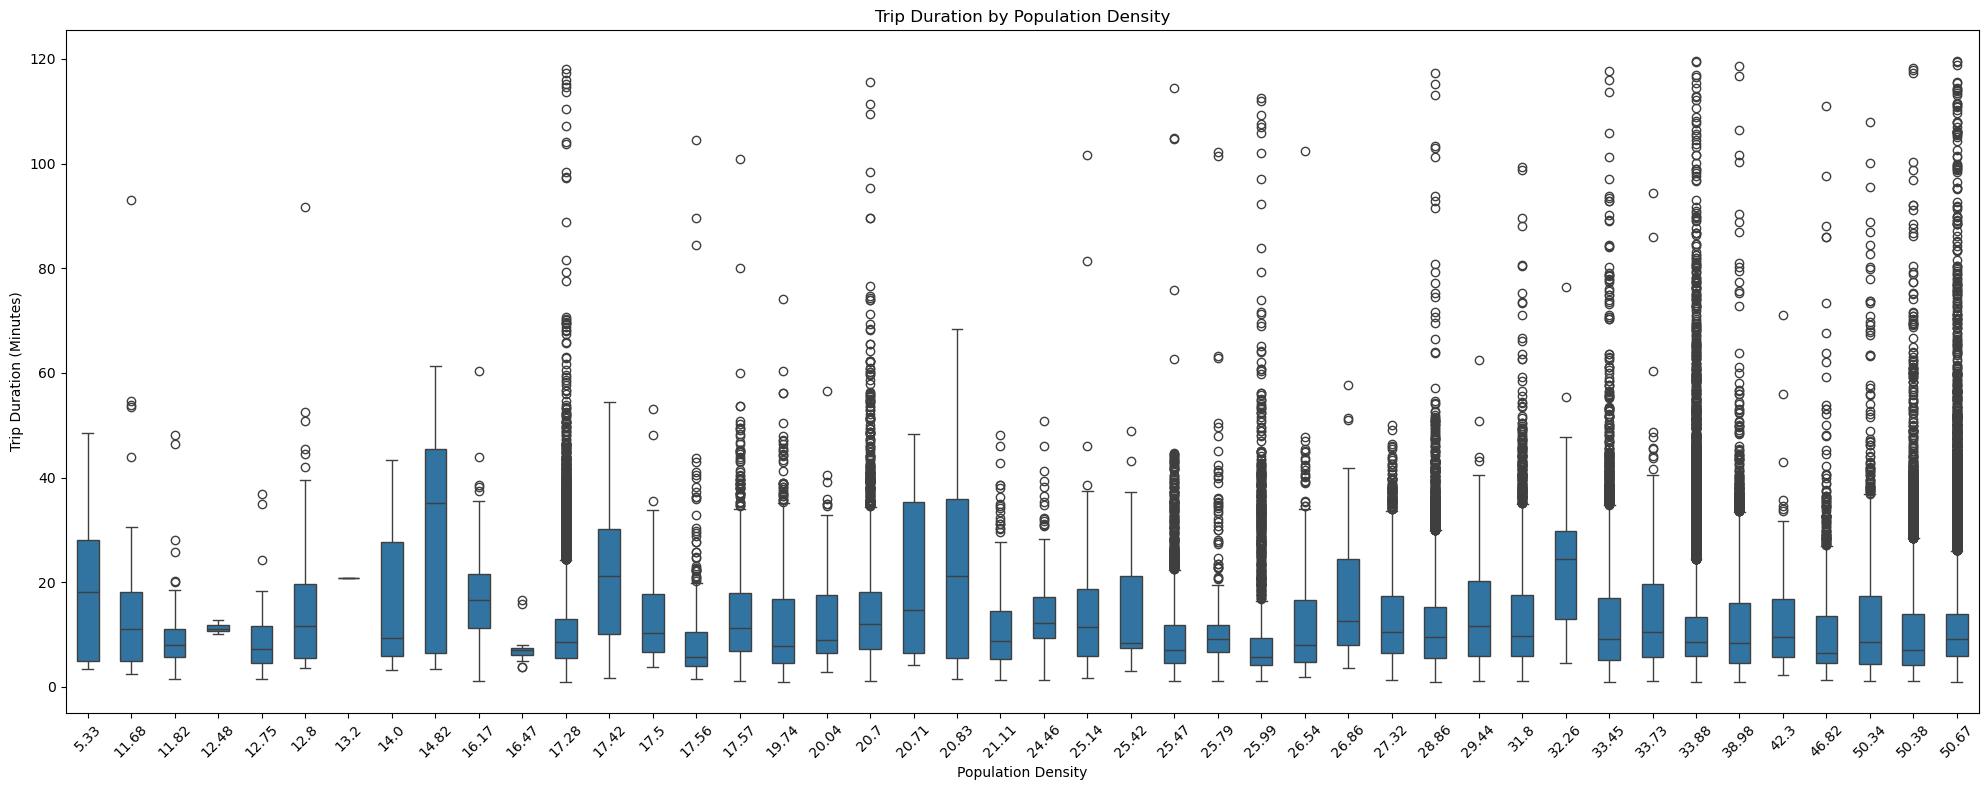

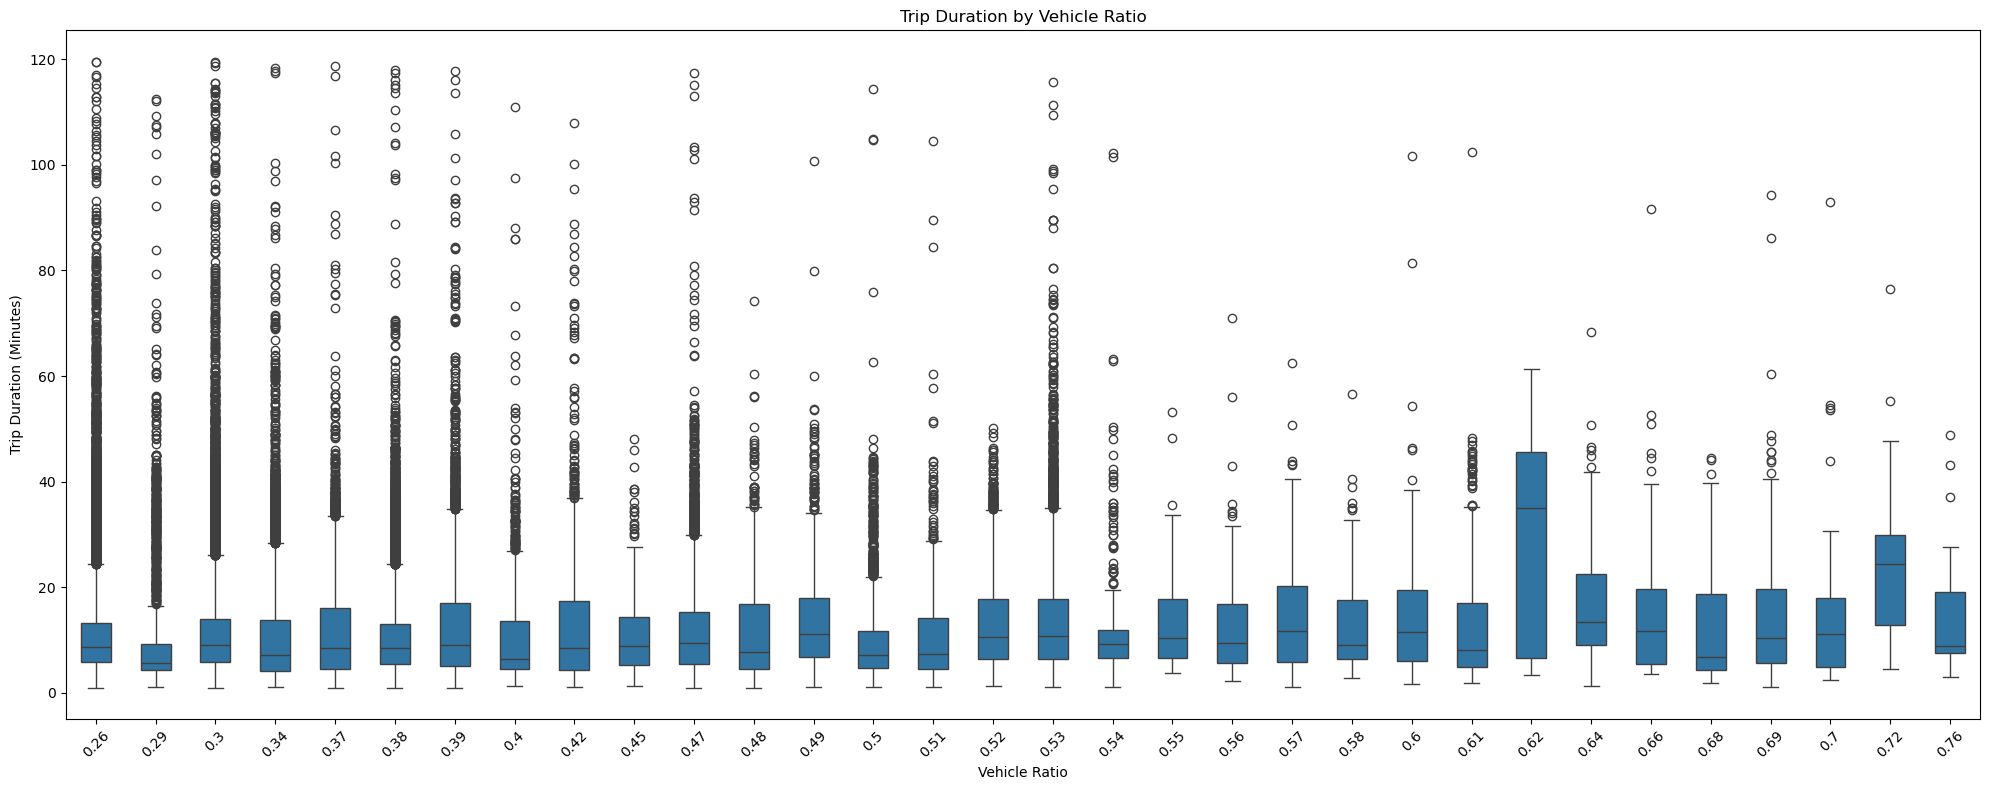

In [17]:
# Plot trip distribution by median income, population density, and vehicle ratio
def plot_trip_distribution_by_feature(feature, title):
    plt.figure(figsize=(20, 8))
    sns.boxplot(
        x=feature,
        y='TRIP DURATION',
        data=bike_community,
        width=0.5,
    )
    plt.title(title)
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Trip Duration (Minutes)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_trip_distribution_by_feature('MEDIAN_INCOME', 'Trip Duration by Median Income')
plot_trip_distribution_by_feature('POPULATION_DENSITY', 'Trip Duration by Population Density')
plot_trip_distribution_by_feature('VEHICLE_RATIO', 'Trip Duration by Vehicle Ratio')

# Remarks about the distribution of Divvy stations 

As we can see from the map and the chart above, the amount of Divvy stations and therefore starting locations of each bikes belong overwhelmingly to 6 communities, which is problematic to our data, since the variance of various metrics as described above might be too low to yield any meaningful understanding. Therefore it is an open question whether or not the inclusion of such geographical data will prove useful for us. Two possible solutions:

+ Underweight samples from overrepresented regions, this could however prove problematic since the vast majority of our data/bike rides start from these regions
+ Find more sample for underrepresented regions, however this could be difficult, since the latest data are from 2019 in the provided dataset and further network expansion will not be present

Therefore, we need to find metrics that apply for each stations individually and not for the community as a whole, new metrics that could be included are:

+ `Avg_Duration`: The average duration of every trips started from this location 
+ `DistanceCBD`: The direct distance to Chicago's Central Business District, this could a proxy, since further out stations might require more bike time to reach their worklplace. 
+ `Bike_lane_density`: The density of nearby bike lanes, since more accessible bike infrastructre will problably leads to shorter and more frequent bike usage, while underserverd areas will be more variable in its usage

In [18]:
import math

# 1) define Chicago CBD coords; We picked the location of Cloud Gate, a well-known landmark in the Chicago CBD, as the symbolic center.
cbd_lat, cbd_lon = 41.8827, -87.62333

# 2) Haversine function (returns km); calculates the distance between two points on the Earth given their longitude and latitude
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0
    φ1, φ2 = math.radians(lat1), math.radians(lat2)
    Δφ = math.radians(lat2 - lat1)
    Δλ = math.radians(lon2 - lon1)
    a = math.sin(Δφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(Δλ/2)**2
    return 2 * R * math.asin(math.sqrt(a))

# 3) aggregate per‐station mean duration
station_stats = (
    bike_community
      .groupby(['FROM STATION ID','FROM LATITUDE','FROM LONGITUDE'])
      .agg(Avg_Duration=('TRIP DURATION','mean'))
      .reset_index()
)

# 4) compute distance to CBD
station_stats['Distance_CBD_km'] = station_stats.apply(
    lambda r: haversine(r['FROM LONGITUDE'], r['FROM LATITUDE'], cbd_lon, cbd_lat),
    axis=1
)

station_stats.head()

,FROM STATION ID,FROM LATITUDE,FROM LONGITUDE,Avg_Duration,Distance_CBD_km
0,2,41.876470,-87.620340,25.501829,0.735644
1,3,41.867226,-87.615355,19.440033,1.842970
2,4,41.856268,-87.613348,24.127225,3.053114
3,5,41.874053,-87.627716,12.036865,1.027787
4,6,41.886976,-87.612813,19.595067,0.992004


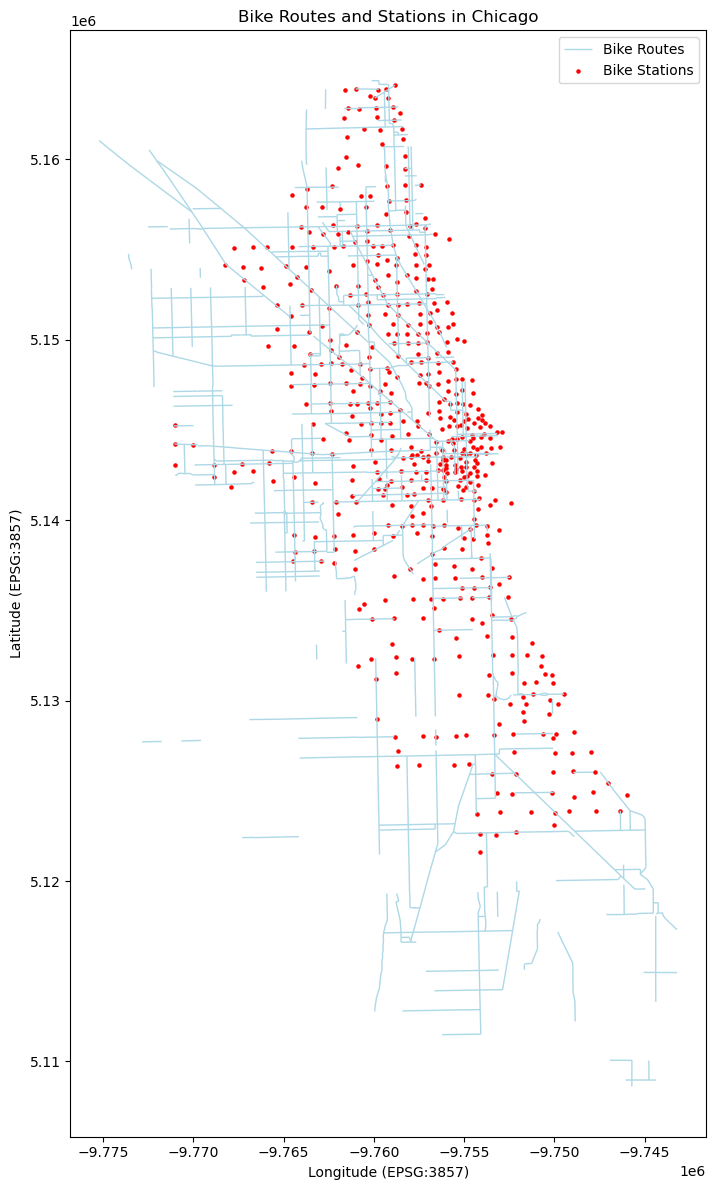

In [19]:
routes = pd.read_csv("Bike_Routes.csv")
routes['the_geom'] = routes['the_geom'].apply(wkt.loads)
routes_gdf = gpd.GeoDataFrame(routes, geometry='the_geom', crs="EPSG:4326")
routes_gdf = routes_gdf.to_crs(epsg=3857)  # Convert to meters

stations = gpd.GeoDataFrame(
    station_stats,
    geometry=gpd.points_from_xy(station_stats['FROM LONGITUDE'], station_stats['FROM LATITUDE']),
    crs="EPSG:4326"
).to_crs(epsg=3857)  # Convert to meters

# Plot the bike routes and stations
fig, ax = plt.subplots(figsize=(12, 12))
routes_gdf.plot(ax=ax, color='lightblue', linewidth=1, label='Bike Routes')
stations.plot(
    ax=ax,
    color='red',
    markersize=5,
    label='Bike Stations'
)
ax.set_title('Bike Routes and Stations in Chicago')
ax.set_xlabel('Longitude (EPSG:3857)')
ax.set_ylabel('Latitude (EPSG:3857)')
ax.legend()
plt.tight_layout()
plt.show()

In [20]:
stations["buffer"] = stations.geometry.buffer(500)
stations["lane_length_m"] = stations["buffer"].apply(
    lambda poly: routes_gdf.intersection(poly).length.sum()
)

stations["Bike_lane_density"] = (
    (stations["lane_length_m"] / 1_000) /
    (stations["buffer"].area / 1e6)
)

In [21]:
bike_community = bike_community.merge(
    stations[['FROM STATION ID','Avg_Duration','Distance_CBD_km','Bike_lane_density']],
    on='FROM STATION ID',
    how='left'
)
bike_community.drop(columns=['FROM LATITUDE', 'FROM LONGITUDE', 'END TIME','geometry', 'index_right', 
                             'COMMUNITY', 'MEDIAN_INCOME', 'POPULATION_DENSITY', 'VEHICLE_RATIO', 'RENTAL_RATIO', 'UNEMPLOYMENT_RATIO'], inplace=True)
bike_community.rename(columns={'OBJECTID': 'COMMUNITY_ID',
                               'FROM STATION ID': 'STATION_ID',
                               'Avg_Duration': 'HISTORICAL_AVG_DURATION',
                               }, inplace=True)

In [22]:
bike_community.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 154990 entries, 0 to 154989
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   START TIME               154990 non-null  datetime64[ns]
 1   BIKE ID                  154990 non-null  int64         
 2   TRIP DURATION            154990 non-null  float64       
 3   STATION_ID               154990 non-null  int64         
 4   USER TYPE                154990 non-null  object        
 5   GENDER                   154990 non-null  object        
 6   AGE                      154990 non-null  int64         
 7   Monday                   154990 non-null  bool          
 8   Tuesday                  154990 non-null  bool          
 9   Wednesday                154990 non-null  bool          
 10  Thursday                 154990 non-null  bool          
 11  Friday                   154990 non-null  bool          
 12  Saturday

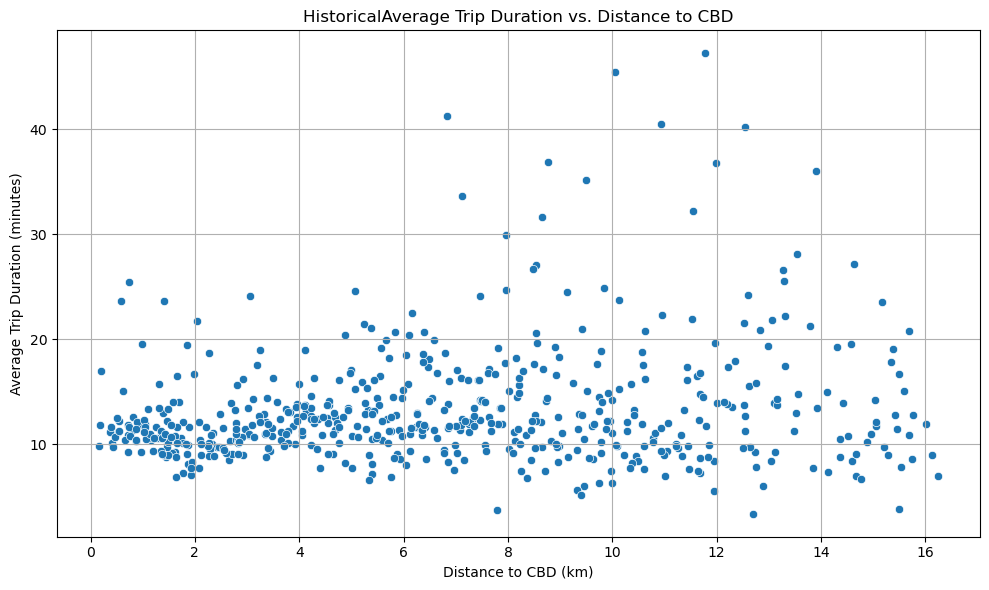

In [23]:
# Plot average trip duration vs. distance to CBD
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Distance_CBD_km',
    y='Avg_Duration',
    data=station_stats,
)
plt.title('HistoricalAverage Trip Duration vs. Distance to CBD')
plt.xlabel('Distance to CBD (km)')
plt.ylabel('Average Trip Duration (minutes)')
plt.grid()
plt.tight_layout()
plt.show()

The scatter plot “Average Trip Duration vs. Distance to CBD” reveals a positive trend: stations located farther from the Central Business District tend to have longer mean trip durations. This makes intuitive sense—riders starting farther out need more time to reach common destinations—so these two variables exhibit a logical relationship. Incorporating `Distance_CBD_km` and `Avg_Duration` into our regression model will leverage this geographic dependency. 

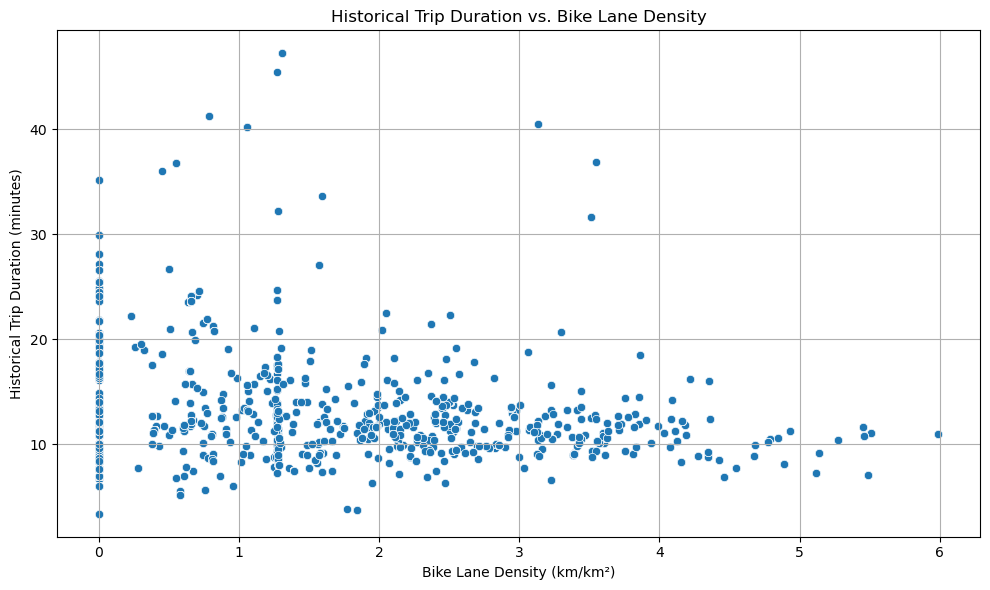

In [24]:
# Plot average trip duration vs. bike lane density
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Bike_lane_density',
    y='HISTORICAL_AVG_DURATION',
    data=bike_community,
)
plt.title('Historical Trip Duration vs. Bike Lane Density')
plt.xlabel('Bike Lane Density (km/km²)')
plt.ylabel('Historical Trip Duration (minutes)')
plt.grid()
plt.tight_layout()
plt.show()

Source for bike lanes: https://data.cityofchicago.org/Transportation/Bike-Routes-Map/3w5d-sru8

**Important**: The bike lanes data is sourced from 2025, since the City of Chicago does not provide any data from before 2024, therefore the accuracy should be taken with a grain of salt, since our data is from 2019

From the chart above we can see that for increasing density, the trip duaration typically falls, since community with more access to bike infrastructure will tend to use them more frequent and for shorter duration. As for undeserved areas, the usage seems to be more variable. This could be due to the fact that their usage in such circumstances will be marked by necessity, rather than choice as denser areas enjoy. 

# Linear Regression and K-Nearest Neighbours

In [25]:
xa = bike_community[["AGE"]]
ya = bike_community["TRIP DURATION"]

X_train, X_test, y_train, y_test = train_test_split(xa, ya, test_size=0.3, random_state = 30)
polyRange = PolynomialFeatures(degree = 3, include_bias = False)
X_train_poly = polyRange.fit_transform(X_train.values.reshape(-1, 1))
X_test_poly = polyRange.fit_transform(X_test.values.reshape(-1, 1))

scaler = StandardScaler()   
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly) # no fit transform, already fitted before

lin_model = LinearRegression()
lin_model.fit(X_train_poly_scaled, y_train)

knn_model = KNeighborsRegressor(n_neighbors = 100)
knn_model.fit(X_train_poly_scaled, y_train)

y_pred_lin = lin_model.predict(X_test_poly_scaled)
y_pred_knn = knn_model.predict(X_test_poly_scaled)  

mae_lin = mean_absolute_error(y_test, y_pred_lin)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

r2_lin = r2_score(y_test, y_pred_lin)
r2_knn = r2_score(y_test, y_pred_knn)

print("LinearRegression:")
print("MAE: ", mae_lin)
print("R2: ", r2_lin)

print("KNN: ")
print("MAE: ", mae_knn)
print("R2: ", r2_knn)

LinearRegression:
MAE:  6.412867579413251
R2:  0.0015294260072621357
KNN: 
MAE:  6.408365446516262
R2:  -0.0036581409987386238


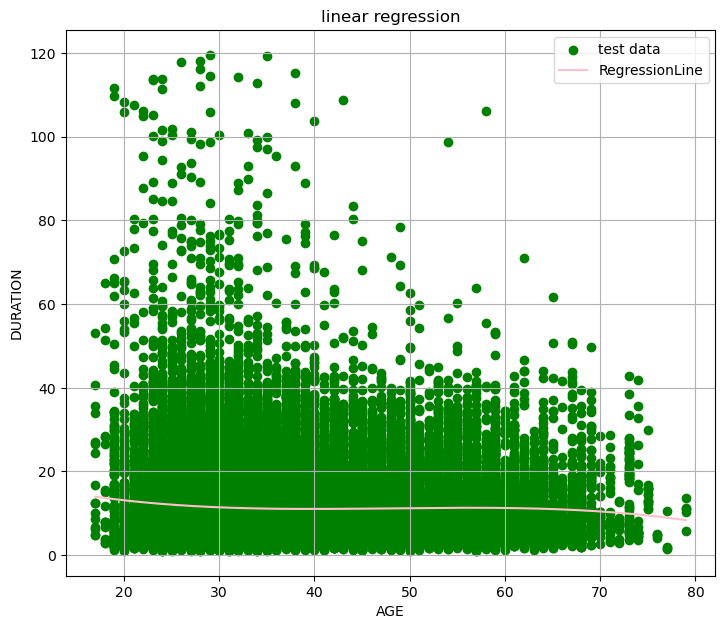

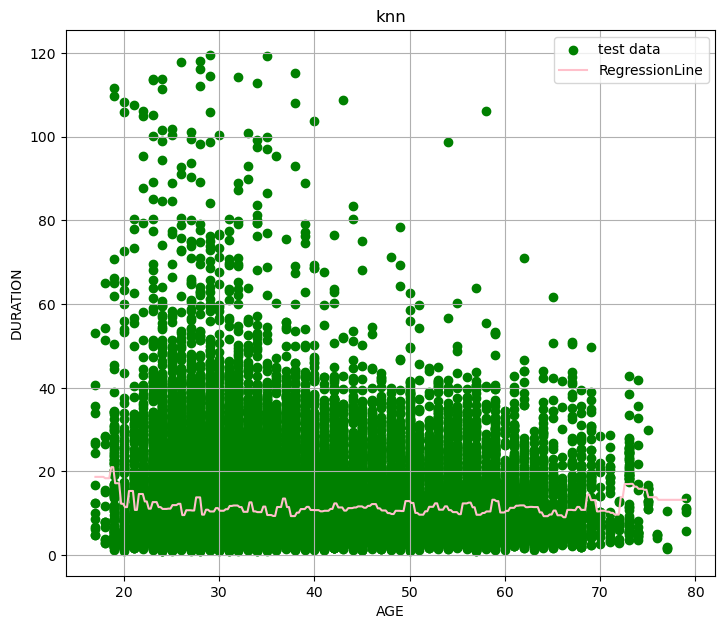

In [26]:
temp_range = np.linspace(X_test.min(), X_test.max(), 300).reshape(-1, 1)
temp_range_poly = polyRange.transform(temp_range)
temp_range_poly_scaled = scaler.transform(temp_range_poly)

y_pred_test = lin_model.predict(X_test_poly_scaled)
y_pred_line = lin_model.predict(temp_range_poly_scaled)

plt.figure(figsize= (14, 12))
plt.subplot(2, 2, 1)
plt.scatter(X_test, y_test, color="green", label= "test data")
plt.plot(temp_range, y_pred_line, color="pink", label = "RegressionLine" )
plt.xlabel("AGE")
plt.ylabel("DURATION")
plt.title("linear regression")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


y_pred_test = knn_model.predict(X_test_poly_scaled)
y_pred_line = knn_model.predict(temp_range_poly_scaled)

plt.figure(figsize= (14, 12))
plt.subplot(2, 2, 2)
plt.scatter(X_test, y_test, color="green", label= "test data")
plt.plot(temp_range, y_pred_line, color="pink", label = "RegressionLine" )
plt.xlabel("AGE")
plt.ylabel("DURATION")
plt.title("knn")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

notes: 
- age as a feature has very low explanatory power -> MAE too high, and R2 very far away from 1 
- knn not suitable in this case
- combine multiple features for better explanatory power